In [1]:
import numpy as np
import os
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transform
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from skimage import io
from glob import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms

#train_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
#test_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'
train_path='/kaggle/input/pix2pix-facades-dataset/facades/train/'
test_path='/kaggle/input/pix2pix-facades-dataset/facades/val/'#

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_images=[]
train_masks=[]
def load_images(path):
    temp_img,temp_mask=[],[]
    images=glob(os.path.join(path,'*.jpg'))
    for i in tqdm(images):
        i=cv2.imread(i)
        i=cv2.normalize(i,None,0,1,cv2.NORM_MINMAX,cv2.CV_32F)
        img=i[:,256:]
        msk=i[:,:256]  
        temp_img.append(img)
        temp_mask.append(msk) 
    return temp_img,temp_mask

train_images,train_masks=load_images(train_path)
test_images,test_masks=load_images(test_path)

100%|██████████| 100/100 [00:01<00:00, 93.89it/s]


In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )

        # Output layer
        self.out_conv = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Encoder
        enc_features = self.encoder(x)

        # Decoder
        dec_features = self.decoder(enc_features)
        
        # Output layer
        output = self.out_conv(dec_features)

        return output

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.layer1 = self.conv2relu(6, 16, 5, cnt=1)
        self.layer2 = self.conv2relu(16, 32, pool_size=4)
        self.layer3 = self.conv2relu(32, 64, pool_size=2)
        self.layer4 = self.conv2relu(64, 128, pool_size=2)
        self.layer5 = self.conv2relu(128, 256, pool_size=2)
        self.layer6 = nn.Conv2d(256, 1, kernel_size=1)

    def conv2relu(self, in_c, out_c, kernel_size=3, pool_size=None, cnt=2):
        layer = []
        for i in range(cnt):
            if i == 0 and pool_size is not None:
                layer.append(nn.AvgPool2d(pool_size))
            layer.append(nn.Conv2d(in_c if i == 0 else out_c,
                                   out_c,
                                   kernel_size,
                                   padding=(kernel_size - 1) // 2))
            layer.append(nn.InstanceNorm2d(out_c))  # Instance Normalization
            layer.append(nn.LeakyReLU(0.2, inplace=True))
        return nn.Sequential(*layer)

    def forward(self, x, x1):
        x = torch.cat((x, x1), dim=1)
        out = self.layer5(self.layer4(self.layer3(self.layer2(self.layer1(x)))))
        return self.layer6(out)

In [5]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
batch_size = 32
epochs = 70


# Define a transformation to normalize the data within the training loop
normalize = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to the range [0, 1]
])

# Create instances of the generator, discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Define loss functions
criterion_bce = nn.BCEWithLogitsLoss()
criterion_mae = nn.L1Loss()

# Optimizers with weight decay
optimizer_g = Adam(generator.parameters(), lr=0.0002,betas=(0.5,0.999))
optimizer_d = Adam(discriminator.parameters(), lr=0.0002,betas=(0.5,0.999))


#generator.apply(weights_init)
#discriminator.apply(weights_init)

train_batches = len(train_images) // batch_size
total_loss_g = []
total_loss_d = []

In [6]:
# Training loop
for epoch in range(epochs):
    print("Epoch : ", epoch + 1)
    for batch in tqdm(range(train_batches)):
        # Get batches
        train_img_batch = train_images[batch * batch_size:(batch + 1) * batch_size]
        train_msk_batch = train_masks[batch * batch_size:(batch + 1) * batch_size]
        
        # Apply normalization within the training loop
        img = torch.stack([normalize(i) for i in train_img_batch])
        mask = torch.stack([normalize(i) for i in train_msk_batch])

        img = img.to(device)
        mask = mask.to(device)

        real_label = torch.ones(img.size()[0], 1, 8, 8).to(device)
        fake_label = torch.zeros(img.size()[0], 1, 8, 8).to(device)

        # Generator
        fake_img = generator(img)
        fake_img_ = fake_img.detach()
        
        # Discriminator
        out_real = discriminator(mask, img)
        loss_d_real = criterion_bce(out_real, real_label)
        
        out_fake = discriminator(fake_img_, img)
        loss_d_fake = criterion_bce(out_fake, fake_label)
        loss_d = loss_d_real + loss_d_fake

        optimizer_d.zero_grad()
        loss_d.backward(retain_graph=True)
        optimizer_d.step()

        # Update generator with adversarial loss
        loss_g_bce = criterion_bce(out_fake, real_label)
        loss_g_mae = criterion_mae(fake_img, mask)
        loss_g = loss_g_bce + 100 * loss_g_mae

        optimizer_g.zero_grad()
        loss_g.backward(retain_graph=True)
        optimizer_g.step()

    print(f"Discriminator Loss: {loss_d.item():.4f}, Generator Loss: {loss_g.item():.4f}")

# Save the trained models if needed
torch.save(generator.state_dict(), 'generator.pth')
torch.save(discriminator.state_dict(), 'discriminator.pth')

Epoch :  1


100%|██████████| 12/12 [00:08<00:00,  1.40it/s]


Discriminator Loss: 1.3815, Generator Loss: 40.8670
Epoch :  2


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 1.3132, Generator Loss: 39.9745
Epoch :  3


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 1.1681, Generator Loss: 39.6273
Epoch :  4


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.9680, Generator Loss: 39.1820
Epoch :  5


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.8870, Generator Loss: 38.3056
Epoch :  6


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.8058, Generator Loss: 38.0757
Epoch :  7


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.7332, Generator Loss: 37.0552
Epoch :  8


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.6796, Generator Loss: 36.3948
Epoch :  9


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.6176, Generator Loss: 36.0123
Epoch :  10


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.5761, Generator Loss: 35.9479
Epoch :  11


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.5473, Generator Loss: 35.4066
Epoch :  12


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.4834, Generator Loss: 34.5289
Epoch :  13


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.4698, Generator Loss: 34.0525
Epoch :  14


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.4751, Generator Loss: 33.7988
Epoch :  15


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.5006, Generator Loss: 32.6237
Epoch :  16


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.3706, Generator Loss: 32.9035
Epoch :  17


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.3554, Generator Loss: 32.7933
Epoch :  18


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.3273, Generator Loss: 32.0143
Epoch :  19


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.3129, Generator Loss: 30.8462
Epoch :  20


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.4602, Generator Loss: 29.1488
Epoch :  21


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2974, Generator Loss: 28.9948
Epoch :  22


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.3292, Generator Loss: 29.4443
Epoch :  23


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.3352, Generator Loss: 27.6471
Epoch :  24


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.2715, Generator Loss: 26.8676
Epoch :  25


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.3284, Generator Loss: 26.3218
Epoch :  26


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.2265, Generator Loss: 26.4997
Epoch :  27


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2124, Generator Loss: 26.0042
Epoch :  28


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1912, Generator Loss: 26.4678
Epoch :  29


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2005, Generator Loss: 25.2639
Epoch :  30


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 1.4362, Generator Loss: 22.8750
Epoch :  31


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 1.3689, Generator Loss: 23.4941
Epoch :  32


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 1.3392, Generator Loss: 22.3920
Epoch :  33


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 1.0910, Generator Loss: 22.2194
Epoch :  34


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.7303, Generator Loss: 21.9549
Epoch :  35


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.4978, Generator Loss: 21.7696
Epoch :  36


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.3630, Generator Loss: 22.1190
Epoch :  37


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.6414, Generator Loss: 21.2633
Epoch :  38


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2942, Generator Loss: 21.9472
Epoch :  39


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.3083, Generator Loss: 21.5485
Epoch :  40


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2735, Generator Loss: 20.5516
Epoch :  41


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.2618, Generator Loss: 20.8074
Epoch :  42


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2171, Generator Loss: 20.0991
Epoch :  43


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.3247, Generator Loss: 19.7130
Epoch :  44


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2409, Generator Loss: 19.6685
Epoch :  45


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1721, Generator Loss: 20.3708
Epoch :  46


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1655, Generator Loss: 19.9610
Epoch :  47


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 1.7462, Generator Loss: 18.1803
Epoch :  48


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.2852, Generator Loss: 19.1387
Epoch :  49


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.1741, Generator Loss: 19.3049
Epoch :  50


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 1.0540, Generator Loss: 19.3692
Epoch :  51


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2156, Generator Loss: 18.5822
Epoch :  52


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1497, Generator Loss: 18.6154
Epoch :  53


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.1436, Generator Loss: 18.6516
Epoch :  54


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 1.4511, Generator Loss: 16.6302
Epoch :  55


100%|██████████| 12/12 [00:02<00:00,  4.15it/s]


Discriminator Loss: 0.5724, Generator Loss: 17.1795
Epoch :  56


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.2006, Generator Loss: 18.4083
Epoch :  57


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1522, Generator Loss: 18.0777
Epoch :  58


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1704, Generator Loss: 18.1282
Epoch :  59


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.1434, Generator Loss: 18.1730
Epoch :  60


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.1266, Generator Loss: 18.2161
Epoch :  61


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1256, Generator Loss: 18.1034
Epoch :  62


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 3.7503, Generator Loss: 16.5315
Epoch :  63


100%|██████████| 12/12 [00:02<00:00,  4.16it/s]


Discriminator Loss: 0.8917, Generator Loss: 15.3638
Epoch :  64


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.6621, Generator Loss: 15.7046
Epoch :  65


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.2568, Generator Loss: 16.9171
Epoch :  66


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.1652, Generator Loss: 16.6643
Epoch :  67


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


Discriminator Loss: 0.1370, Generator Loss: 16.6589
Epoch :  68


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1470, Generator Loss: 17.4114
Epoch :  69


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1489, Generator Loss: 16.8985
Epoch :  70


100%|██████████| 12/12 [00:02<00:00,  4.17it/s]


Discriminator Loss: 0.1973, Generator Loss: 16.2816


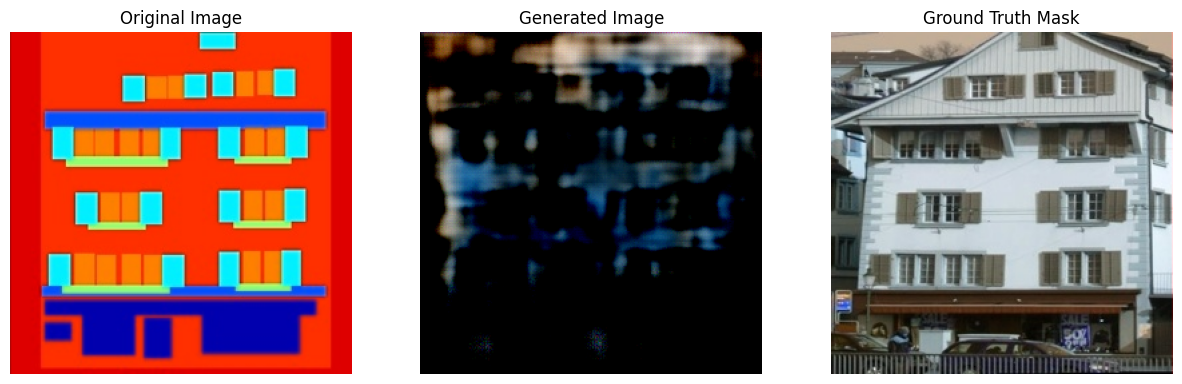

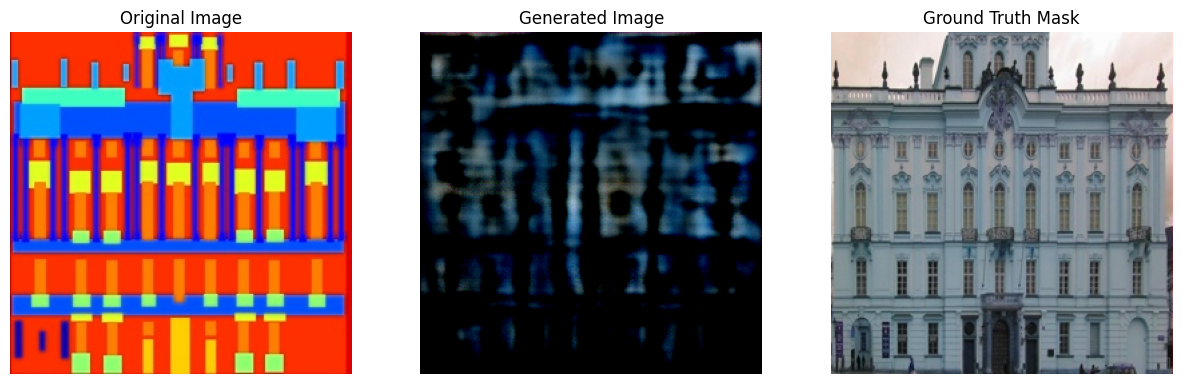

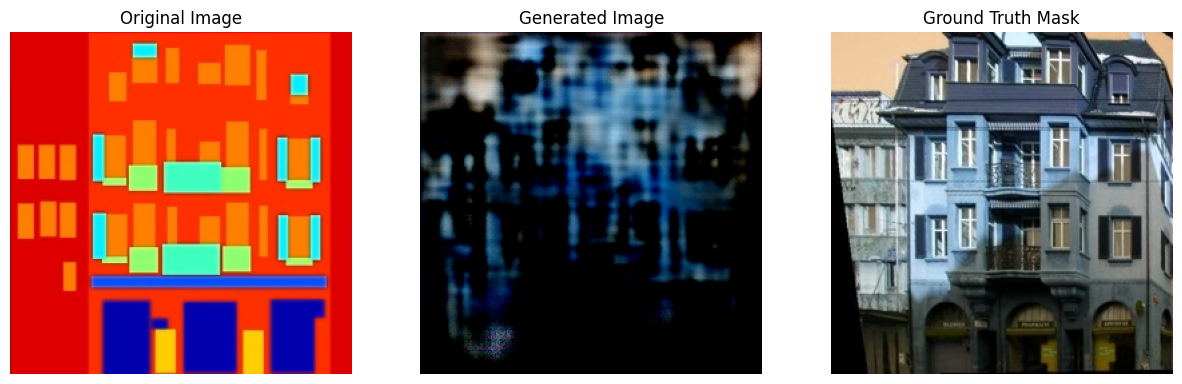

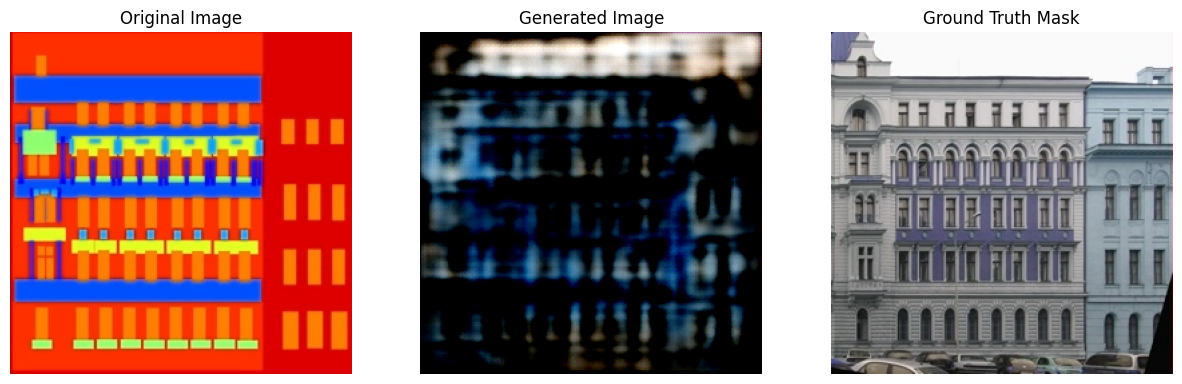

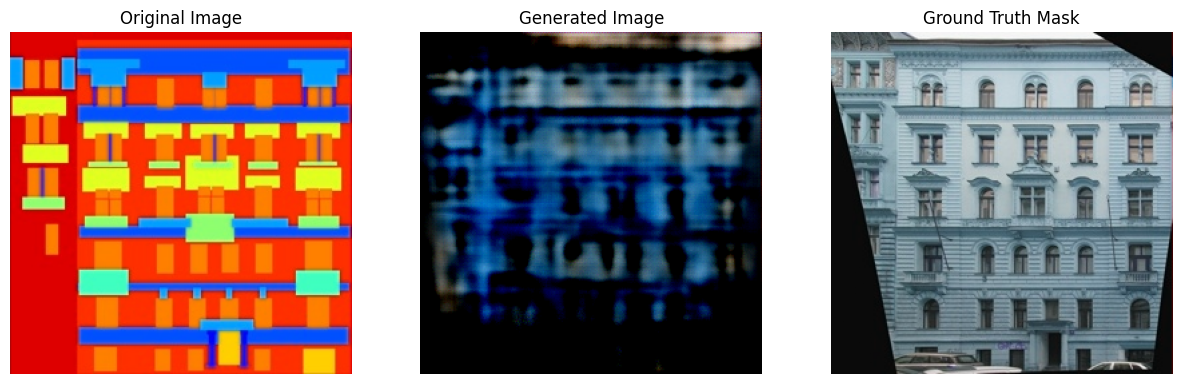

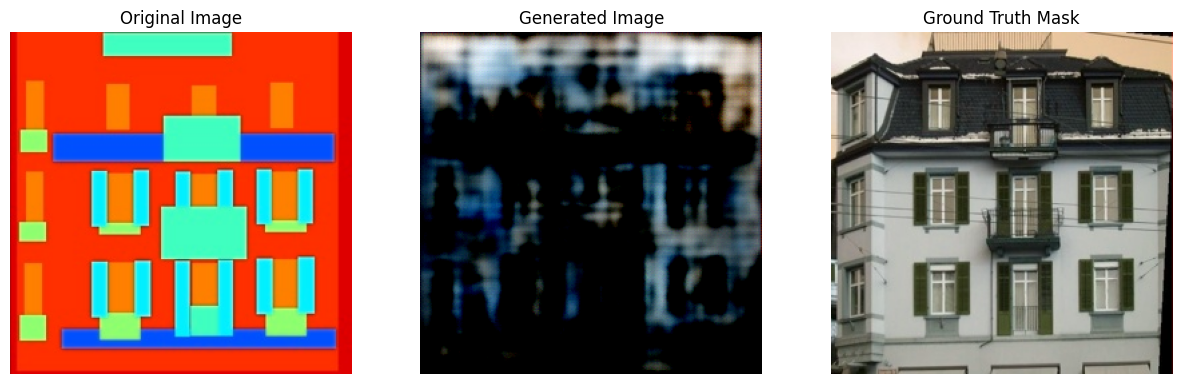

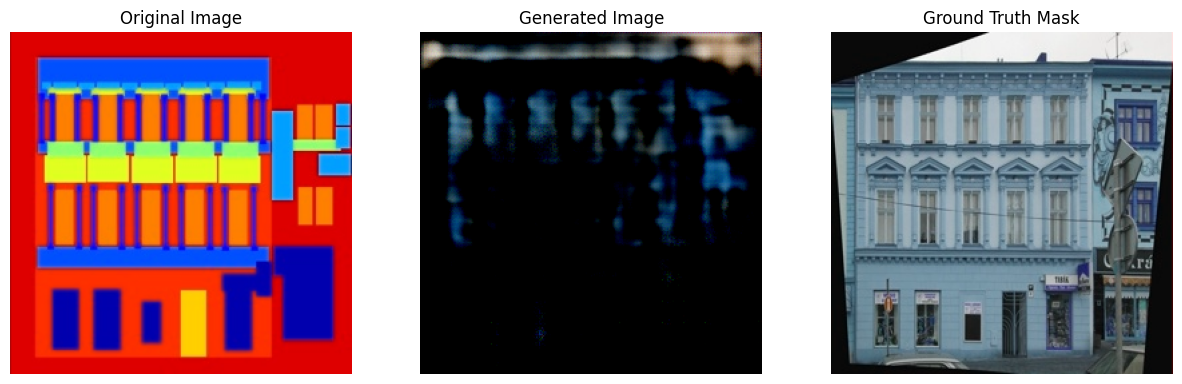

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator_state_dict = torch.load('/kaggle/working/generator.pth', map_location=device)
discriminator_state_dict = torch.load('/kaggle/working/discriminator.pth', map_location=device)

# Create model instances
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load the state dictionaries into the models
generator.load_state_dict(generator_state_dict)
discriminator.load_state_dict(discriminator_state_dict)

# Set models to evaluation mode
generator.eval()
discriminator.eval()

def display_images_row(images, titles):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.show()

# Randomly select a few samples from the test set
num_samples_to_visualize = 10
random_indices = np.random.choice(len(test_images), num_samples_to_visualize, replace=False)

for idx in random_indices:
    test_img = test_images[idx]
    test_msk = test_masks[idx]
    
    img = normalize(test_img)
    mask = normalize(test_msk)
    
    img = np.reshape(img, (1, 3, 256, 256)).to(device)
    mask = np.reshape(mask, (1, 3, 256, 256)).to(device)
    
    #Forward pass through the generator
    with torch.no_grad():
        generated_images = generator(img)

    # Convert tensors to numpy arrays for visualization
    generated_image_np = generated_images[0].detach().cpu().numpy().transpose(1,2,0)
    original_image_np = test_img
    mask_np = test_msk
    # Display images in a row
    display_images_row(
        [original_image_np, generated_image_np, mask_np],
        ['Original Image', 'Generated Image', 'Ground Truth Mask']
    )
